In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cap = cv2.VideoCapture("./test2.mp4")

In [12]:
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plt.imshow(frame)

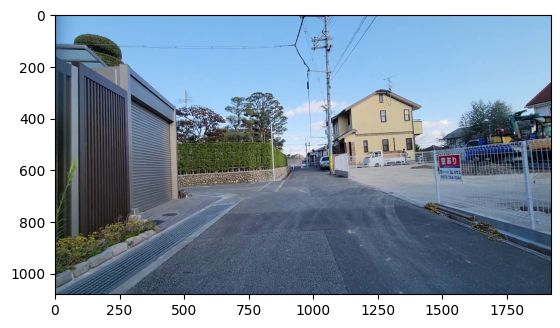

In [14]:
plt.imshow(img1)

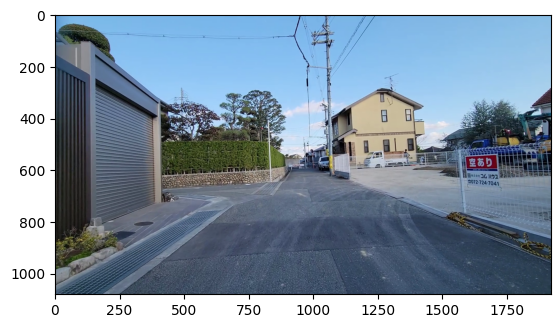

In [15]:
plt.imshow(img2)

### 特徴抽出
ORB特徴量を計算する

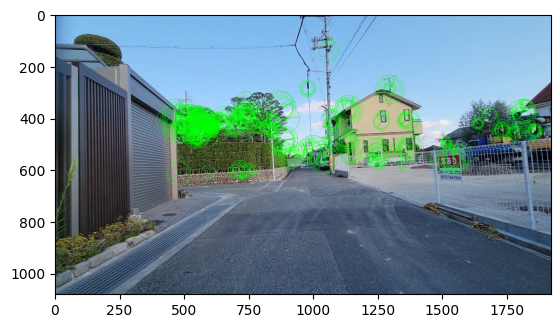

In [17]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
img1_orb = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0), flags=4)
plt.imshow(img1_orb)

### 特徴量マッチング
前フレームと特徴量を比較し、現実世界で同じと考えられる点同士をマッチングする

True

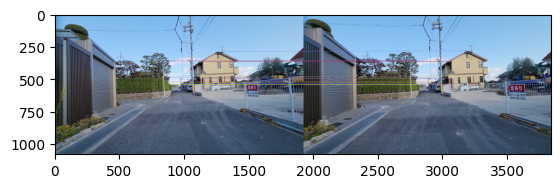

In [21]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
match_result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:25], None, flags=2)
plt.imshow(match_result)
cv2.imwrite("./match_result.png", cv2.cvtColor(match_result, cv2.COLOR_RGB2BGR))

In [27]:
points1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
points2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

In [29]:
# カメラの内部パラメータ（仮定の例。実際はキャリブレーションによって得る）
K = np.array([[700, 0, 320],
              [0, 700, 240],
              [0, 0, 1]])

In [32]:
E, mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, mask = cv2.recoverPose(E, points1, points2, K)

In [34]:
R, t

(array([[ 9.99961231e-01, -8.34265663e-03, -2.81726210e-03],
        [ 8.34198233e-03,  9.99965174e-01, -2.51013204e-04],
        [ 2.81925810e-03,  2.27501922e-04,  9.99996000e-01]]),
 array([[-0.61030654],
        [-0.38086413],
        [-0.69459948]]))

In [57]:
cap = cv2.VideoCapture("./test2.mp4")

ret, frame = cap.read()
cnt = 0
img2 = frame.copy()
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
K = np.array(
    [
        [700, 0, 320],
        [0, 700, 240],
        [0, 0, 1]
    ]
)
p = np.array([[0.0, 0.0, 0.0]]).T
poses = [p]

while ret:
    ret, frame = cap.read()
    if cnt == 5:
        img1 = img2.copy()
        img2 = frame.copy()
        
        # ORB特徴量の算出
        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)

        # 特徴点マッチング
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)

        # 位置推定
        points1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
        points2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
        E, mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        _, R, t, mask = cv2.recoverPose(E, points1, points2, K)
        p = np.dot(R, p) + t
        poses.append(p)
        print(p[:, :2])
        
        cnt = 0
        continue
    
    cnt += 1

[[-0.7079698 ]
 [-0.27035648]
 [-0.65244627]]
[[-1.17082634]
 [-0.78597315]
 [-1.38536004]]
[[-1.68957695]
 [-1.14640624]
 [-2.15922129]]
[[-2.42290653]
 [-1.21732071]
 [-2.87220103]]
[[-3.54525745]
 [-0.7922762 ]
 [-3.05028713]]
[[-3.86588598]
 [-1.28746961]
 [-3.87880394]]
[[-4.45623414]
 [-1.66975895]
 [-4.58578333]]
[[-5.50160033]
 [-2.96688629]
 [-3.12631812]]
[[-4.85749968]
 [-2.56206389]
 [-2.39493146]]
[[-5.77584275]
 [-2.33837444]
 [ 0.27743635]]
[[-4.81766425]
 [-2.32913143]
 [ 1.13595542]]
[[-3.76622223]
 [-2.10746954]
 [ 2.12311555]]
[[-2.60841132]
 [-1.76400724]
 [ 2.74496971]]
[[-1.42319722]
 [-1.36416046]
 [ 3.31072082]]
[[-0.35169642]
 [-0.81609009]
 [ 3.69760751]]
[[ 0.56837693]
 [-0.1661715 ]
 [ 4.20825322]]
[[1.41607425]
 [0.26632792]
 [4.5776296 ]]
[[2.66663906]
 [0.48411798]
 [4.58027253]]
[[3.54143689]
 [1.10993658]
 [4.9957051 ]]
[[4.28438803]
 [1.60472479]
 [5.54820675]]
[[4.04318254]
 [1.11032643]
 [4.75857732]]
[[3.53324695]
 [0.7411514 ]
 [4.03121931]]
[[2.95

In [58]:
poses_arr = np.array(poses).squeeze()

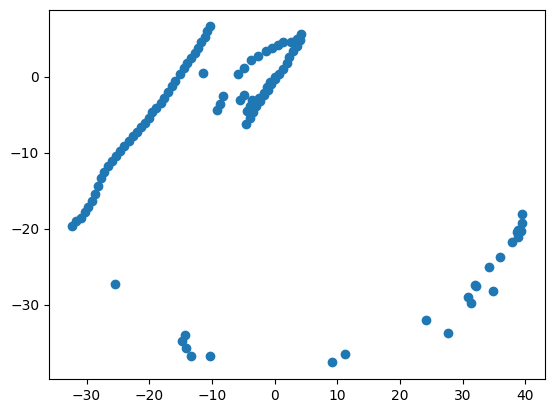

In [61]:
plt.scatter(poses_arr[:, 0], poses_arr[:, 2])

## SLAMの必要性
これまでは予め作られた高精度地図を購入し、それを自己位置推定に使っていた（はず）。<br>
この方法だと、環境が変わった時にそれに追いついていけず、現実世界と地図で不整合が生じる可能性がある。<br>
定期的に地図を更新する必要があるが、それにもさらにコストがかかる。

一方SLAMはリアルタイムで周囲の環境をマッピングしながら位置を推定<br>
環境が変化（建物が工事で増えたり変わったりする等）してもそれに適応でき、<br>
そこを通れば常に最新の地図が作れる。<br>
また、オドメトリを使って未知の場所でも位置を把握しつつ地図を作り続けることが可能。<br>

## 使われるセンサとメリデメ比較

## Visual SLAMとは？ 代表的な手法の比較
ORBとLSD

## ざっくりとした処理の流れ
### 特徴量抽出
画像から何かしらの特徴量を抽出する(点、線、エッジなど）。<br>
ORB SLAMでは、ORB特徴量と呼ばれる点を使用する。他の特徴量抽出アルゴリズムと比べて速いらしい。<br>
画像中の色々な場所で特徴点が検出され、この点を自己位置推定や地図作成に使用する。

### 特徴量マッチングと姿勢推定
現在のフレームと前のフレームの特徴量を比較する。<br>
現実世界で同じ点はカメラの移動に伴い違うピクセルに移動するはず。<br>
その移動量や向きを使ってカメラが前回からどれくらい移動・回転したかを推定する。<br>
直進すると放射状、カーブを曲がるときは左右に動く感じ。<br>
IMUを使って安定性、精度を上げる方法もあるらしい。

### 自己位置推定
カメラの姿勢が分かったら、2D空間の特徴量を3D空間に投影できる。単眼の場合、三角測量と呼ばれる方法を使う。<br>
他にも深さ情報を使ったり、ステレオ視を使ったりする方法もあるとか。<br>
3D空間に投影した点が地図上のどこにあるかをマッチングして自己位置推定する。<br>
初見の道の場合は、オドメトリを使って前回からどれだけ移動したかで自己位置を決める。<br>

### 地図の更新
地図は3D空間の点で構成されている。地図中の自己位置に対して現在の点を地図に反映する。

### ループ閉込み
初見の道を走り続けていると現実世界に対する位置の誤差が蓄積してしまう（前回からの移動量で自己位置推定しているから）。<br>
この時、一度来たことがある道に再び到達した場合、前に通った位置と大きくずれてしまうことがある。<br>
そこで、一度来たことがある場所に到達したことを検出した場合、それまでに作った地図と自己位置を補正してくれる。<br>
運転中知らない道を通り続けた後知ってる道を通過したとき、今の自分の位置やそれまでの道がどこに繋がってるかが分かってくるみたいなイメージ。

## センサ構成案
* 単眼
* ステレオカメラ
* IMU付き

## 今後の進め方